In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

import sys
sys.path.append("../../")

from pipeline.utils.stats import Stats

Using TensorFlow backend.


In [2]:
# Load in the time_series from the previous stage in the pipeline
correlations = feather.read_dataframe("../../data_files/B/once/75days/5mins/best_correlations_offset_5mins_code_hour_day.feather")
correlations = correlations.set_index(correlations.columns[0])


In [3]:
# time_series = feather.read_dataframe("../data_files/B/once/35days/10mins/diff_percent_from_code_hour_day_-_full_segment_time_series.feather")
# time_series = time_series.set_index(time_series.columns[0])

# time_series = time_series.rename(renamer, axis="columns")

In [4]:
stop_events = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_interp.feather",
# stop_events = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     'date', 'stopCode', 'aimedArrival', 'aimedDeparture', 'actualArrival', 'actualDeparture', 'prev_stopCode', 'prev_aimedArrival',
       'prev_aimedDeparture', 'prev_actualArrival', 'prev_actualDeparture',
       'timingPoint', 'prev_timingPoint', 'arrival_hour', 'segment_code', 'segment_name', 'line_distance', 'to_centre_dist', 'direction_degrees', 'train', 'test','full_duration','median_full_durations_by_segment_code',
       'median_full_durations_by_segment_code_and_hour',
       'median_full_durations_by_segment_code_and_hour_and_day',
       'diff_full_segment_and_median_by_segment_code',
       'diff_full_segment_and_median_by_segment_code_and_hour_and_day',
       'diff_percent_full_segment_and_median_by_segment_code',
       'diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day',
       'offset_timestamp', 'arrival_5mins', 'rain',
                                     'diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day',
                                     "workid", "segment_duration",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "median_durations_by_segment_code_and_hour_and_day","dry","weekend",
                                     "timetable_segment_duration",
            "std_diff_percent_segment_mean_by_segment_code_and_hour_and_day",
            "clock_direction_degrees","arrival_day",
                                    ])



stop_events = stop_events.set_index("index")
stop_events.head()

stop_events["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    stop_events["segment_duration"]
    - stop_events["mean_durations_by_segment_code_and_hour_and_day"]
)


stop_events["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    stop_events["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / stop_events["mean_durations_by_segment_code_and_hour_and_day"]
)

stop_events["arrival_5mins"] = stop_events["actualArrival"].dt.round("5min")
stop_events['offset_timestamp'] = stop_events["arrival_5mins"] - pd.Timedelta("5 min")


In [36]:
stop_events["arrival_day"] = stop_events['actualArrival'].dt.dayofweek

In [5]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

stop_events = filter_rare(stop_events)

Calculating rare segments...
	Calculated


In [6]:
# stop_events["arrival_1hour"] = stop_events["date"] + pd.to_timedelta(stop_events["arrival_hour"].values, unit="h")
# stop_events['offset_timestamp'] = stop_events["arrival_1hour"] - pd.Timedelta("1 hour")

stop_events["arrival_5mins"] = stop_events["actualArrival"].dt.round("5min")
stop_events['offset_timestamp'] = stop_events["arrival_5mins"] - pd.Timedelta("5 min")
# stop_events["offset_timestamp"] = stop_events["arrival_10mins"]


In [7]:
# We need to generate this from scratch as we need both test and train data. 
time_series = stop_events.pivot_table(
        index="arrival_5mins",
        columns="segment_code",
        values="diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day",
        aggfunc=np.mean,
    )

In [8]:
time_series_padded = time_series.interpolate(method='pad', axis=0, limit=11)

In [28]:
# weather = pd.read_csv("../../weather/CDO9610867945337_weather.csv")


# weather['date'] = pd.to_datetime(weather[' YEARMODA'], format="%Y%m%d")
# weather['rain'] = weather['PRCP  '].apply(lambda x: float(x[:-1]))

# just_rain = weather[['date', 'rain']]

In [29]:
# stop_events = stop_events.merge(just_rain, left_on="date", right_on="date")

In [11]:
se = stop_events

segment_code_and_hour_and_day_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "arrival_day"]
)

std_diff_percent_segment_mean_by_segment_code_and_hour_and_day = (
    segment_code_and_hour_and_day_groups[
        "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"
    ]
    .std()
    .rename("std_diff_percent_segment_mean_by_segment_code_and_hour_and_day")
)
se = se.merge(
    std_diff_percent_segment_mean_by_segment_code_and_hour_and_day.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "arrival_day"],
    right_index=True,
)

In [14]:
stop_events = stop_events.merge(correlations, left_on="segment_code", right_index=True)

In [15]:
def best(row):
    try:
        value = time_series_padded.loc[row[0],row[1]] 
    except: 
#         print("--------------")
#         print(row.name)
#         print(row[0])
#         print(row[1])
        value = np.nan
    return value

In [16]:
tqdm.pandas("My Bar")

In [17]:
stop_events['best_0'] = stop_events[['offset_timestamp', '0']].progress_apply(best, axis=1)

In [18]:
stop_events['self_offset'] = stop_events[['offset_timestamp', 'segment_code']].progress_apply(best, axis=1)

In [19]:
def do_mape(actual_thing, predict):
    
    with np.errstate(divide='ignore', invalid='ignore'):

        division = (actual_thing[:,None] - predict)/actual_thing[:,None]

        division[actual_thing == 0, :] = 0

        mape = 100 / np.count_nonzero(actual_thing) * np.sum(np.abs(division), axis=0)

    return mape

def brute_force_mapes(stop_e, 
                      window=5,
                      thing="segment_duration",
                      base="mean_durations_by_segment_code_and_hour_and_day",
                      diff="diff_percent_segment_and_mean_by_segment_code_and_hour_and_day", 
                      absolute=False, speed=False, log=False):

    time_s = stop_e.pivot_table(
        index=f"arrival_{window}mins",
        columns="segment_code",
        values=diff,
        aggfunc=np.mean,
    ).interpolate(
        method="pad", axis=0, limit=11
    ).replace([np.inf, np.nan, -np.inf], 0)
    
    segments = stop_e.groupby('segment_code')

    best_preds = []
    best_code_pairs = []
    test_events_per_segement = []
#     bayesian_predict = []

    for segment_code, segment_events in tqdm(segments):
        
        # Train stage

        actual_thing = segment_events[segment_events['train']][thing].values
        
        actual_thing_indicies = segment_events[segment_events['train']].index

        actual_base = segment_events[segment_events['train']][base].values

#         predict_array = time_s.loc[segment_events[segment_events['train']][f"arrival_{window}mins"].values]
        
        predict_array = time_s.loc[segment_events[segment_events['train']]["offset_timestamp"].values - pd.Timedelta(f"15 min")]

#         predict = actual_base[:,None] * (1+(predict_array/100))
        
        if(absolute):
            predict = actual_base[:,None] + predict_array
        else:
            predict = actual_base[:,None] * (1+(predict_array/100))
            
        if(speed):
            predict = segment_events.iloc[0,:]['line_distance']/predict
            
        if(log):
            predict = np.exp(predict)
            
        mape = do_mape(actual_thing, predict.values)
            
        best_columns = np.argsort(mape)
        
        best_code_pairs.append([segment_code, time_s.columns[best_columns[0]]])
        
        se.loc[actual_thing_indicies, 'wrapper_pred'] = predict_array.values[:,best_columns[0]]
        
#         clf = BayesianRidge()
        
#         clf.fit(predict.iloc[:, best_columns[:10]].replace(np.nan, 0), actual_thing)
        
        
        # Test stage
        
        actual_thing_test = segment_events[segment_events['test']][thing].values
        actual_thing_test_indices = segment_events[segment_events['test']].index
        
        if(np.count_nonzero(actual_thing_test) == 0):
            best_preds.append([np.nan] * time_s.shape[1])
            test_events_per_segement.append(0)
#             bayesian_predict.append(0)
            continue 

        actual_base_test = segment_events[segment_events['test']][base].values

#         predict_array_test = time_s.loc[segment_events[segment_events['test']][f"arrival_{window}mins"].values]
        predict_array_test = time_s.loc[segment_events[segment_events['test']]["offset_timestamp"].values - pd.Timedelta(f"15 min") ]
        
        if(absolute):
            predict_test = actual_base_test[:,None] + predict_array_test
        else:
            predict_test = actual_base_test[:,None] * (1+(predict_array_test/100))
            
        if(speed):
            predict_test = segment_events.iloc[0,:]['line_distance']/predict_test
        
        
        predict_test = predict_test.iloc[:,best_columns]
        
#         predict_bayesian_test = clf.predict(predict_test.iloc[:,best_columns[:10]].replace(np.nan, 0))
        
        if(log):
            predict_test = np.exp(predict_test)
#             predict_bayesian_test = np.exp(predict_bayesian_test)

        se.loc[actual_thing_test_indices, 'wrapper_pred'] = predict_array_test.values[:,best_columns[0]]
        
        mape_test = do_mape(actual_thing_test, predict_test.values)
        
#         mape_bayes_test = do_mape(actual_thing_test, predict_bayesian_test[:,None])
        
        best_preds.append(mape_test)
        test_events_per_segement.append(actual_base_test.shape[0])
#         bayesian_predict.append(float(mape_bayes_test))
        
    best_preds = np.array(best_preds)
    best_code_pairs = np.array(best_code_pairs)
    test_events_per_segement = np.array(test_events_per_segement).squeeze()
#     bayesian_predict = np.array(bayesian_predict, dtype=float)
    
    total_test = np.count_nonzero(stop_e['test'])
    
    ma = np.ma.MaskedArray(best_preds, mask=np.isnan(best_preds))
    weighted_mapes = np.ma.average(ma, weights=test_events_per_segement, axis=0)
    
#     print(bayesian_predict.dtype, test_events_per_segement.dtype)
    
#     weighted_bayes_mape = np.average(bayesian_predict, weights=test_events_per_segement)
            
    plt.plot(weighted_mapes[:30])
    plt.title(f"Using {base}\nto predict {thing} with {window}min time windows")
    plt.show()
        
    return best_preds, weighted_mapes# bayesian_predict, weighted_bayes_mape
            
    

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


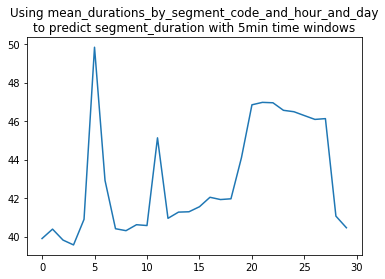

In [20]:
se = stop_events

stop_events['wrapper_pred'] = 0

best_preds,weighted_mapes = brute_force_mapes(stop_events);

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


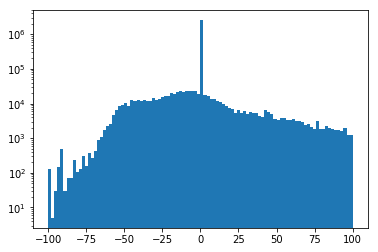

In [21]:
plt.hist(se.loc[se['train'], "wrapper_pred"], bins=100, range=(-100,100));
plt.yscale("log")

In [22]:
np.count_nonzero(se['test'] & se['wrapper_pred'])/np.count_nonzero(se['test'])*100


23.403364140033386

In [24]:
print(f"percent nan for best_0: {stop_events['best_0'].isna().sum()/stop_events.shape[0]*100}")
print(f"percent nan for self_offset: {stop_events['self_offset'].isna().sum()/stop_events.shape[0]*100}")

percent nan for best_0: 35.15095408558086
percent nan for self_offset: 15.380999783751326


In [25]:
stop_events['best_0'] = stop_events['best_0'].replace([np.nan, -np.inf], 0)
stop_events['self_offset'] = stop_events['self_offset'].replace([np.nan, -np.inf], 0)

In [26]:
stop_events = stop_events.dropna(axis=0)

In [109]:
# train_matrix = stop_events[stop_events['train']][['arrival_hour', 'line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', '30', 'self_offset', 'rain']]
train_matrix = stop_events[stop_events['train']][['arrival_hour', 
                                                  'line_distance', 
                                                  'to_centre_dist', 
                                                  'direction_degrees', 
                                                  'rain', 
                                                  "dry", 
                                                  "weekend",
                                                  "timetable_segment_duration",
                                                    "clock_direction_degrees","arrival_day"]]


# train_matrix = pd.concat((train_matrix, stop_events[stop_events['train']][['best_0', '30', 'self_offset']]), axis=1)

train_target = stop_events[stop_events['train']]['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'].values

# test_matrix = stop_events[stop_events['test']][['arrival_hour', 'line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', '30', 'self_offset', 'rain']]
test_matrix = stop_events[stop_events['test']][['arrival_hour', 
                                                  'line_distance', 
                                                  'to_centre_dist', 
                                                  'direction_degrees', 
                                                  'rain', 
                                                  "dry", 
                                                  "weekend",
                                                  "timetable_segment_duration",
                                                    "clock_direction_degrees","arrival_day"]]

# test_matrix = pd.concat((test_matrix, stop_events[stop_events['test']][['best_0', '30', 'self_offset']]), axis=1)

test_target = stop_events[stop_events['test']]['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'].values

test_target = np.nan_to_num(test_target)

In [110]:
train_matrix = pd.get_dummies(train_matrix, columns=["arrival_hour", "arrival_day"])
test_matrix = pd.get_dummies(test_matrix, columns=["arrival_hour", "arrival_day"])

In [111]:
stop_events.isna().sum(axis=0).max()

0

In [112]:
print(stop_events[stop_events['train']].shape)
print(train_matrix.shape)
print(train_target.shape)

(3253010, 106)
(3253010, 35)
(3253010,)


In [113]:
# stop_events['30']

In [114]:
poly = PolynomialFeatures(2)
reg = LinearRegression().fit(train_matrix, train_target)

reg_results = reg.predict(test_matrix)

In [115]:
reg.score(test_matrix, test_target)



0.0039808792012705485

In [116]:
rmse_lr = np.sqrt(mean_squared_error(test_target, reg_results))
mae_lr = mean_absolute_error(test_target, reg_results)


In [117]:
print(rmse_lr)
print(mae_lr)


87.93104038540311
43.66546104991648


In [118]:
reg.coef_

array([-6.68521097e+01,  1.88228967e-01, -1.94721448e-02,  7.63370192e-01,
       -3.39311681e-01,  1.55648456e+00,  5.86075646e-02, -1.74808713e-02,
        7.88646419e+00, -3.75922444e+00,  1.99653755e+00,  1.51251099e+00,
        1.71568390e+00,  2.38572091e+00, -6.38137903e-01, -1.71729167e+00,
       -2.30080045e+00, -2.61151851e+00, -3.07979013e+00, -2.73783805e+00,
       -3.34239567e+00, -2.23067312e+00, -5.65372069e-01,  1.40988270e+00,
        1.11573290e+00,  1.22772148e+00,  1.48798656e+00,  2.24480084e+00,
       -8.59477230e-02, -7.83049126e-02, -5.63606425e-01, -3.77285711e-01,
       -4.51339792e-01,  3.75130808e-01,  1.18135376e+00])

In [119]:
data_dmatrix = xgb.DMatrix(data=train_matrix,label=train_target)


In [120]:
xg_reg = xgb.XGBRegressor(eval_metric='mae', booster='gbtree', n_jobs=8, max_depth=5, n_estimators=300)

In [121]:
xg_reg.fit(train_matrix, train_target)

xg_reg_results = xg_reg.predict(test_matrix)

In [122]:
rmse_xg = np.sqrt(mean_squared_error(test_target, xg_reg_results))
mae_xg = mean_absolute_error(test_target, xg_reg_results)

In [123]:
print(rmse_xg)
print(mae_xg)

85.8680975951835
43.78275728317654


In [124]:
# xg_reg.feature_importances_

In [125]:
scaler_matrix = preprocessing.StandardScaler().fit(train_matrix)

train_matrix_scaled = scaler_matrix.transform(train_matrix)
test_matrix_scaled = scaler_matrix.transform(test_matrix)

scaler_target = preprocessing.StandardScaler().fit(train_target[:,None])

train_target_scaled = scaler_target.transform(train_target[:,None])
test_target_scaled = scaler_target.transform(test_target[:,None])




/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [126]:
def create_fully_connected(input_width):
    model = Sequential()
    
    model.add(Dense(32, input_dim=input_width, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(1, activation='tanh'))
    model.summary()
    
    return model

In [127]:
model = create_fully_connected(train_matrix.shape[1])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    keras.callbacks.ModelCheckpoint(filepath='full_conn_model.h5', monitor='val_loss', save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['MAE'])
history = model.fit(train_matrix_scaled, train_target_scaled,
                    epochs=10,
                    callbacks=callbacks_list,
                    batch_size=512,
                    validation_data=(test_matrix_scaled, test_target_scaled))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                1152      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_14 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_15 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 13        
Total para

In [128]:
model_to_load = 'full_conn_model.h5'

# Create the network and load the weights into it
model = create_fully_connected(test_matrix.shape[1])
model.load_weights(model_to_load)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
test_y_scaled = model.predict(test_matrix_scaled)

NN_results = scaler_target.inverse_transform(test_y_scaled).squeeze()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                1152      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_17 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_18 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 13        
Total para

In [129]:
rmse_NN = np.sqrt(mean_squared_error(test_target, NN_results))
mae_NN = mean_absolute_error(test_target, NN_results)


In [130]:
print(rmse_NN)
print(mae_NN)

90.01162198232304
40.717511475410156


In [131]:
rmse_best_0 = np.sqrt(mean_squared_error(test_target, stop_events[stop_events['test']]['best_0']))
mae_best_0 = mean_absolute_error(test_target, stop_events[stop_events['test']]['best_0'])

In [132]:
print(rmse_best_0)
print(mae_best_0)

114.68186153819414
55.09656764987059


In [133]:
rmse_self = np.sqrt(mean_squared_error(test_target, stop_events[stop_events['test']]['self_offset']))
mae_self = mean_absolute_error(test_target, stop_events[stop_events['test']]['self_offset'])

In [134]:
print(rmse_self)
print(mae_self)

113.88047801845813
56.73815264877368


In [135]:
rmse_null = np.sqrt(mean_squared_error(test_target, [0]*len(test_target)))
mae_null = mean_absolute_error(test_target, [0]*len(test_target))

In [136]:
print(rmse_null)
print(mae_null)

90.01368912810146
40.717423553943895


In [137]:
# plt.hist(NN_results, alpha=0.5, bins=100, label="NN", range=(-100, 100))
# plt.hist(xg_reg_results, bins=100, label="XGB", alpha=0.5,  range=(-100, 100))
# # plt.hist(reg_results, bins=100, label="Linear", alpha=0.5,  range=(-100, 100))
# plt.hist(stop_events[stop_events['test']]['best_0'], bins=100, alpha=0.5,  label="best_0", range=(-100, 100))
# # plt.hist(stop_events['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'], bins=200, label="target", range=(-100, 100))
# # plt.hist(train_target, bins=200, label="train", range=(-100, 100))
# plt.hist(test_target, bins=100, label="target", alpha=0.5,  range=(-100, 100))
# # plt.yscale("log")
# plt.legend()

# plt.show()


In [138]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

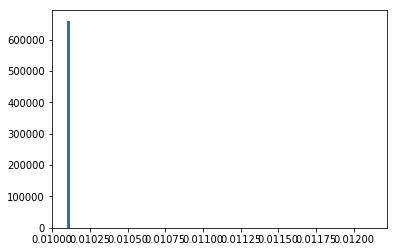

In [139]:
plt.hist(NN_results.squeeze(), bins=100);

In [140]:
stats = Stats(stop_events[stop_events['test']])


../../pipeline/utils/stats.py:20: RuntimeWarning: invalid value encountered in less
  self.first_20mins_mask = actual_array_cum < 20 * 60


In [141]:
stats.full_stats(tests=[
    reg_results,
    xg_reg_results,
    NN_results.squeeze(),
    stop_events[stop_events['test']]['best_0'],
    stop_events[stop_events['test']]['self_offset']
], names=[
    "Linear",
    "XGBoost",
    "NN",
    "Best Correlation",
    "Self Offset"
], data_type="diff")

 & MAPE & RMSE & MAE & PW10 & MAPE & RMSE & MAE & PW10 \\
Mean (chd) & 36.295 & 34.901 & 15.911 & 25.232 & 16.955 & 151.179 & 97.603 & 39.082 \\
Median (chd) & 26.413 & 36.555 & 14.653 & 33.557 & 17.027 & 203.746 & 124.710 & 41.029 \\
Linear & 50.337 & 35.978 & 18.814 & 14.515 & 25.420 & 194.993 & 138.150 & 22.712 \\
XGBoost & 53.001 & 37.378 & 19.127 & 15.466 & 25.153 & 195.104 & 135.650 & 24.634 \\
NN & 36.301 & 34.901 & 15.912 & 25.245 & 16.957 & 151.169 & 97.605 & 39.075 \\
Best Correlation & 56.373 & 54.888 & 23.371 & 19.341 & 27.257 & 243.422 & 150.147 & 27.878 \\
Self Offset & 61.718 & 58.974 & 24.431 & 18.380 & 29.497 & 272.944 & 163.084 & 26.093 \\


' & MAPE & RMSE & MAE & PW10 & MAPE & RMSE & MAE & PW10 \\\\\nMean (chd) & 36.295 & 34.901 & 15.911 & 25.232 & 16.955 & 151.179 & 97.603 & 39.082 \\\\\nMedian (chd) & 26.413 & 36.555 & 14.653 & 33.557 & 17.027 & 203.746 & 124.710 & 41.029 \\\\\nLinear & 50.337 & 35.978 & 18.814 & 14.515 & 25.420 & 194.993 & 138.150 & 22.712 \\\\\nXGBoost & 53.001 & 37.378 & 19.127 & 15.466 & 25.153 & 195.104 & 135.650 & 24.634 \\\\\nNN & 36.301 & 34.901 & 15.912 & 25.245 & 16.957 & 151.169 & 97.605 & 39.075 \\\\\nBest Correlation & 56.373 & 54.888 & 23.371 & 19.341 & 27.257 & 243.422 & 150.147 & 27.878 \\\\\nSelf Offset & 61.718 & 58.974 & 24.431 & 18.380 & 29.497 & 272.944 & 163.084 & 26.093 \\\\\n'

In [ ]:
predict_reg = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(reg_results/100))

predict_xg = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(xg_reg_results/100))

predict_NN = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(NN_results.squeeze()/100))

predict_best_0 = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(stop_events[stop_events['test']]['best_0']/100))

predict_self_offset = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(stop_events[stop_events['test']]['self_offset']/100))

predict_null = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"]


In [ ]:
print(f"Linear MAPE: {MAPE(predict_reg, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"XGBoost MAPE: {MAPE(predict_xg, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"NN MAPE: {MAPE(predict_NN, stop_events[stop_events['test']]['full_duration'])}")
            
print(f"Best_0 MAPE: {MAPE(predict_best_0, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"self_offset MAPE: {MAPE(predict_self_offset, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"self_null MAPE: {MAPE(predict_null, stop_events[stop_events['test']]['full_duration'])}")

In [ ]:
# plt.hist(stop_events['30'], bins=100);

In [44]:
train_matrix.shape

(3253010, 35)

In [108]:
os.system("say -v Fiona Go check your results - predictions") 

0

In [ ]:
plt.hist(NN_results, bins=100, range=(-.1,.1));